In [ ]:
# imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import geodatasets
from pathlib import Path
from matplotlib import font_manager
from matplotlib.patches import Rectangle, ConnectionPatch
from matplotlib.gridspec import GridSpec

# data folder
data_folder = '../01_data/'
figure_folder = '../04_documents/02_supplement_figures/'

In [ ]:
# input files, static boundaries still
annual_metrics = pd.read_csv(Path(data_folder) / '04_final_demographic_data/01_static_boundaries/gudd_annual_metrics_static_boundaries.csv')
change_data = pd.read_csv(Path(data_folder) / '04_final_demographic_data/01_static_boundaries/gudd_change_2000_2020_static_boundaries.csv')

In [ ]:
# setup font and world gdf
font_prop = font_manager.FontProperties(family="DejaVu Sans Mono")
world = gpd.read_file(Path(data_folder) / '02_auxiliary_data/03_mapping/ne_50m_admin_0_countries.shp')

In [16]:
# limit annual metrics to only include 2020, for plotting
annual_metrics_2020 = annual_metrics[
    (annual_metrics["YearOfBirth"] <= 2000) &
    (annual_metrics["YearOfDeath"] >= 2020) &
    (annual_metrics["year"] == 2020)
].copy()

change_data = change_data[
    (change_data["YearOfBirth"] <= 2000) &
    (change_data["YearOfDeath"] >= 2020)
].copy()

# Section S2 - detailed stats table for 5 largest cities in each region

In [ ]:
# Filter data for 2000-2020
df_full = annual_metrics[(annual_metrics["year"] >= 2000) & (annual_metrics["year"] <= 2020)].copy()

# Aggregate over 2000-2020 by city
agg_df = df_full.groupby(["Continent","Name","Country"], as_index=False).agg(
    total_pop=("total_pop", "max"),  # use 2020 population
    pop_change=("pop_change", "sum"),
    births=("births", "sum"),
    deaths_total=("deaths_total", "sum"),
    natural_change=("natural_change", "sum"),
    migration=("migration", "sum")
)

# Get top 5 cities per continent by 2020 population
top_cities_per_continent = agg_df.groupby("Continent", group_keys=False).apply(
    lambda x: x.nlargest(5, "total_pop")
)

# Rename columns
top_cities_per_continent = top_cities_per_continent.rename(columns={
    "total_pop": "Total Population (2020)",
    "pop_change": "Population Change (2000-2020)",
    "births": "Total Births (2000-2020)",
    "deaths_total": "Total Deaths (2000-2020)",
    "natural_change": "Natural Change (2000-2020)",
    "migration": "Net Migration (2000-2020)"
}).reset_index(drop=True)

output_file = Path(figure_folder) / 'top_cities_per_continent.csv'
top_cities_per_continent.to_csv(output_file, index = False)
top_cities_per_continent.head()

,Name,Country,Total Population (2020),Population Change (2000-2020),Total Births (2000-2020),Total Deaths (2000-2020),Natural Change (2000-2020),Net Migration (2000-2020)
0,Sydney,Australia,3.346587e+06,1189.744141,938486.690971,416581.774373,476042.011296,-474852.267156
1,Melbourne,Australia,3.033334e+06,2821.843750,784785.854073,354098.677325,392337.063717,-389515.219967
2,Auckland,New Zealand,1.285476e+06,266182.061035,349336.053474,128945.162223,202567.461957,63614.599078
3,Perth,Australia,1.132860e+06,1576.141602,295019.339796,126219.152902,154364.393388,-152788.251787
4,Brisbane,Australia,1.085192e+06,1638.145020,294414.250230,122020.334955,157945.140055,-156306.995035


# Section S3 - Young Sex Ratio

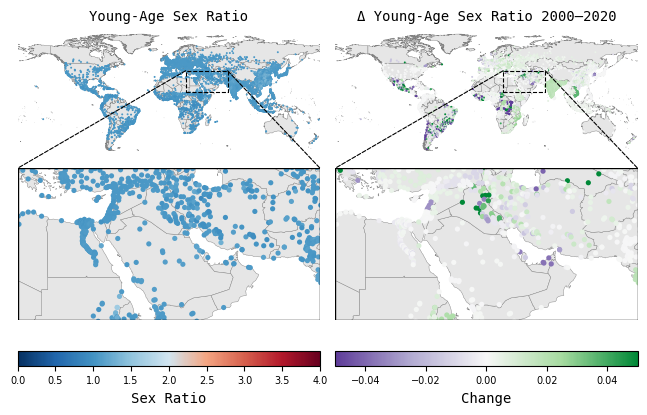

In [ ]:
# colormaps
colors_sr = [
    "#053061", "#2166AC", "#4393C3", "#92C5DE",
    "#D1E5F0", "#F4A582", "#D6604D", "#B2182B", "#67001F"
]

colors_delta = [
    "#5e3c99", "#b2abd2", "#f7f7f7", "#a6dba0", "#008837"
]

cmap_sr = mcolors.LinearSegmentedColormap.from_list("sr", colors_sr)
cmap_delta = mcolors.LinearSegmentedColormap.from_list("delta", colors_delta)

# inset region
INSET_XMIN = 20
INSET_XMAX = 70
INSET_YMIN = 15
INSET_YMAX = 40

highlight = change_data[change_data["young_sr_Delta"] > 0.5]

# draw region box on main map
def draw_region_box(ax):
    rect = Rectangle(
        (INSET_XMIN, INSET_YMIN),
        INSET_XMAX - INSET_XMIN,
        INSET_YMAX - INSET_YMIN,
        fill=False,
        linestyle="--",
        linewidth=0.8,
        edgecolor="black",
        zorder=4
    )
    ax.add_patch(rect)

# draw box around inset panel
def draw_inset_panel_box(ax):
    rect = Rectangle(
        (0,0), 1, 1,
        transform=ax.transAxes,
        fill=False,
        linewidth=1,
        edgecolor="black",
        zorder=5
    )
    ax.add_patch(rect)

# connect top corners
def connect_axes(fig, ax_main, ax_inset):
    con1 = ConnectionPatch(
        xyA=(INSET_XMIN, INSET_YMAX),
        coordsA=ax_main.transData,
        xyB=(0,1),
        coordsB=ax_inset.transAxes,
        linestyle="--",
        linewidth=0.8,
        color="black"
    )
    con2 = ConnectionPatch(
        xyA=(INSET_XMAX, INSET_YMAX),
        coordsA=ax_main.transData,
        xyB=(1,1),
        coordsB=ax_inset.transAxes,
        linestyle="--",
        linewidth=0.8,
        color="black"
    )
    fig.add_artist(con1)
    fig.add_artist(con2)

# plotting function
def plot_map(
    ax,
    data,
    column,
    cmap,
    title,
    vmin,
    vmax,
    inset=False,
    region_box=False,
    inset_box=False,
    highlight_points=None
):
    world.plot(
        ax=ax,
        color="#E6E6E6",
        edgecolor="0.5",
        linewidth=0.3,
        zorder=1
    )

    # slightly larger symbols in inset maps
    base_size = 14 if inset else 2

    # plot all points first
    sc = ax.scatter(
        data["longitude"],
        data["latitude"],
        c=data[column],
        cmap=cmap,
        s=base_size,
        vmin=vmin,
        vmax=vmax,
        linewidth=0,
        zorder=2
    )

    # overlay highlight points in bright yellow
    highlight_handle = None
    if highlight_points is not None and len(highlight_points):
        hl_size = 18 if inset else 8
        highlight_handle = ax.scatter(
            highlight_points["longitude"],
            highlight_points["latitude"],
            s=hl_size,
            facecolor="#ffc425",
            edgecolor="black",
            linewidth=0.3,
            zorder=3,
            label=f"Cities Δ > 0.5"
        )

    if region_box:
        draw_region_box(ax)
    if inset_box:
        draw_inset_panel_box(ax)

    if inset:
        ax.set_xlim(INSET_XMIN, INSET_XMAX)
        ax.set_ylim(INSET_YMIN, INSET_YMAX)
    else:
        ax.set_xlim(-180,180)
        ax.set_ylim(-55,90)

    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_title(
        title,
        fontproperties=font_prop,
        fontsize=10
    )

    return sc, highlight_handle

# figure layout
fig, axes = plt.subplots(
    2,2,
    figsize=(8,6),
    gridspec_kw={'hspace':0.05, 'wspace':0.05}
)

# main maps
sc1,_ = plot_map(
    axes[0,0],
    annual_metrics_2020,
    "young_sr",
    cmap_sr,
    "Young-Age Sex Ratio",
    0,4,
    region_box=True
)

vmin_delta, vmax_delta = -0.05, 0.05

sc2, hl = plot_map(
    axes[0,1],
    change_data,
    "young_sr_Delta",
    cmap_delta,
    "Δ Young-Age Sex Ratio 2000–2020",
    vmin_delta,
    vmax_delta,
    region_box=True,
    highlight_points=highlight
)

# inset maps
sc3,_ = plot_map(
    axes[1,0],
    annual_metrics_2020,
    "young_sr",
    cmap_sr,
    "",
    0,4,
    inset=True,
    inset_box=True
)

sc4,_ = plot_map(
    axes[1,1],
    change_data,
    "young_sr_Delta",
    cmap_delta,
    "",
    vmin_delta,
    vmax_delta,
    inset=True,
    inset_box=True,
    highlight_points=highlight
)

# connectors for inset
connect_axes(fig, axes[0,0], axes[1,0])
connect_axes(fig, axes[0,1], axes[1,1])

#colorbars
cbar1 = fig.colorbar(
    sc1,
    ax=[axes[0,0], axes[1,0]],
    orientation="horizontal",
    fraction=0.05,
    pad=0.08
)
cbar1.set_label("Sex Ratio", fontproperties=font_prop)
cbar1.ax.tick_params(labelsize=7) 


cbar2 = fig.colorbar(
    sc2,
    ax=[axes[0,1], axes[1,1]],
    orientation="horizontal",
    fraction=0.05,
    pad=0.1
)
cbar2.set_label("Change", fontproperties=font_prop)
cbar2.ax.tick_params(labelsize=7)  

# legend for highlight section
if hl is not None:
    axes[1,1].legend(
        frameon=True,
        fontsize=7,
        prop=font_prop,
        loc='lower left',
        markerscale=1.5,
        facecolor='white',
        framealpha=0.7
    )

# final spacing
plt.subplots_adjust(
    wspace=0.02,
    hspace=0.01,
    bottom=0.2,
    top=0.75
)

output_file = Path(figure_folder) / 'figs3_ysr_map.pdf'
fig.savefig(
    output_file,
    format="pdf",
    bbox_inches='tight',
    pad_inches=0,
    dpi=300
)


plt.show()

# Section S4: Old-Age Sex Ratio

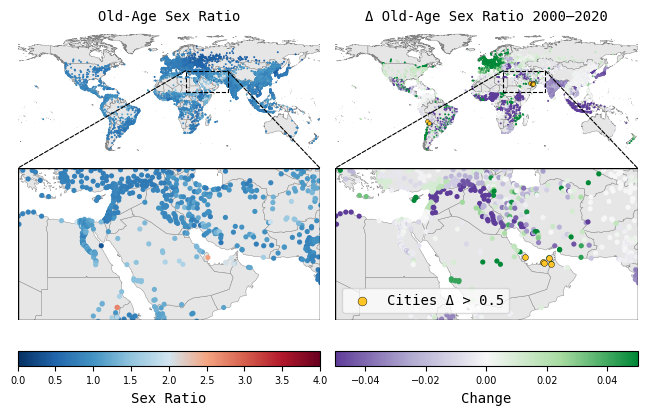

In [ ]:
# colorap setup
colors_sr = [
    "#053061", "#2166AC", "#4393C3", "#92C5DE",
    "#D1E5F0", "#F4A582", "#D6604D", "#B2182B", "#67001F"
]

colors_delta = [
    "#5e3c99", "#b2abd2", "#f7f7f7", "#a6dba0", "#008837"
]

cmap_sr = mcolors.LinearSegmentedColormap.from_list("sr", colors_sr)
cmap_delta = mcolors.LinearSegmentedColormap.from_list("delta", colors_delta)

# inset region - arabia
INSET_XMIN = 20
INSET_XMAX = 70
INSET_YMIN = 15
INSET_YMAX = 40

highlight = change_data[change_data["old_sr_Delta"] > 0.5]

# draw region box on main map
def draw_region_box(ax):
    rect = Rectangle(
        (INSET_XMIN, INSET_YMIN),
        INSET_XMAX - INSET_XMIN,
        INSET_YMAX - INSET_YMIN,
        fill=False,
        linestyle="--",
        linewidth=0.8,
        edgecolor="black",
        zorder=4
    )
    ax.add_patch(rect)

# box around inset panel
def draw_inset_panel_box(ax):
    rect = Rectangle(
        (0,0), 1, 1,
        transform=ax.transAxes,
        fill=False,
        linewidth=1,
        edgecolor="black",
        zorder=5
    )
    ax.add_patch(rect)

# connect top corners
def connect_axes(fig, ax_main, ax_inset):
    con1 = ConnectionPatch(
        xyA=(INSET_XMIN, INSET_YMAX),
        coordsA=ax_main.transData,
        xyB=(0,1),
        coordsB=ax_inset.transAxes,
        linestyle="--",
        linewidth=0.8,
        color="black"
    )
    con2 = ConnectionPatch(
        xyA=(INSET_XMAX, INSET_YMAX),
        coordsA=ax_main.transData,
        xyB=(1,1),
        coordsB=ax_inset.transAxes,
        linestyle="--",
        linewidth=0.8,
        color="black"
    )
    fig.add_artist(con1)
    fig.add_artist(con2)

# plot function
def plot_map(
    ax,
    data,
    column,
    cmap,
    title,
    vmin,
    vmax,
    inset=False,
    region_box=False,
    inset_box=False,
    highlight_points=None
):
    world.plot(
        ax=ax,
        color="#E6E6E6",
        edgecolor="0.5",
        linewidth=0.3,
        zorder=1
    )

    # slightly larger symbols in inset maps
    base_size = 14 if inset else 2

    # plot all points first
    sc = ax.scatter(
        data["longitude"],
        data["latitude"],
        c=data[column],
        cmap=cmap,
        s=base_size,
        vmin=vmin,
        vmax=vmax,
        linewidth=0,
        zorder=2
    )

    # overlay highlight points in bright yellow
    highlight_handle = None
    if highlight_points is not None and len(highlight_points):
        hl_size = 18 if inset else 8
        highlight_handle = ax.scatter(
            highlight_points["longitude"],
            highlight_points["latitude"],
            s=hl_size,
            facecolor="#ffc425",
            edgecolor="black",
            linewidth=0.3,
            zorder=3,
            label=f"Cities Δ > 0.5"
        )

    if region_box:
        draw_region_box(ax)
    if inset_box:
        draw_inset_panel_box(ax)

    if inset:
        ax.set_xlim(INSET_XMIN, INSET_XMAX)
        ax.set_ylim(INSET_YMIN, INSET_YMAX)
    else:
        ax.set_xlim(-180,180)
        ax.set_ylim(-55,90)

    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_title(
        title,
        fontproperties=font_prop,
        fontsize=10
    )

    return sc, highlight_handle

# figure layout
fig, axes = plt.subplots(
    2,2,
    figsize=(8,6),
    gridspec_kw={'hspace':0.05, 'wspace':0.05}
)

# main maps
sc1,_ = plot_map(
    axes[0,0],
    annual_metrics_2020,
    "old_sr",
    cmap_sr,
    "Old-Age Sex Ratio",
    0,4,
    region_box=True
)

vmin_delta, vmax_delta = -0.05, 0.05

sc2, hl = plot_map(
    axes[0,1],
    change_data,
    "old_sr_Delta",
    cmap_delta,
    "Δ Old-Age Sex Ratio 2000–2020",
    vmin_delta,
    vmax_delta,
    region_box=True,
    highlight_points=highlight
)

# inset maps
sc3,_ = plot_map(
    axes[1,0],
    annual_metrics_2020,
    "old_sr",
    cmap_sr,
    "",
    0,4,
    inset=True,
    inset_box=True
)

sc4,_ = plot_map(
    axes[1,1],
    change_data,
    "old_sr_Delta",
    cmap_delta,
    "",
    vmin_delta,
    vmax_delta,
    inset=True,
    inset_box=True,
    highlight_points=highlight
)

# connectors
connect_axes(fig, axes[0,0], axes[1,0])
connect_axes(fig, axes[0,1], axes[1,1])

# colorbars
cbar1 = fig.colorbar(
    sc1,
    ax=[axes[0,0], axes[1,0]],
    orientation="horizontal",
    fraction=0.05,
    pad=0.08
)
cbar1.set_label("Sex Ratio", fontproperties=font_prop)
cbar1.ax.tick_params(labelsize=7) 


cbar2 = fig.colorbar(
    sc2,
    ax=[axes[0,1], axes[1,1]],
    orientation="horizontal",
    fraction=0.05,
    pad=0.1
)
cbar2.set_label("Change", fontproperties=font_prop)
cbar2.ax.tick_params(labelsize=7) 

# legend for highlight (yellow)
if hl is not None:
    axes[1,1].legend(
        frameon=True,
        fontsize=7,
        prop=font_prop,
        loc='lower left',
        markerscale=1.5,
        facecolor='white',
        framealpha=0.7
    )

# final spacing
plt.subplots_adjust(
    wspace=0.02,
    hspace=0.01,  
    bottom=0.2,
    top=0.75    
)

output_file = Path(figure_folder) / 'figs4_osr_map.pdf'
fig.savefig(
    output_file,
    format="pdf",
    bbox_inches='tight',
    pad_inches=0,
    dpi=300
)

plt.show()

# Section S5: Old-Age Dependency Ratio Boxplot

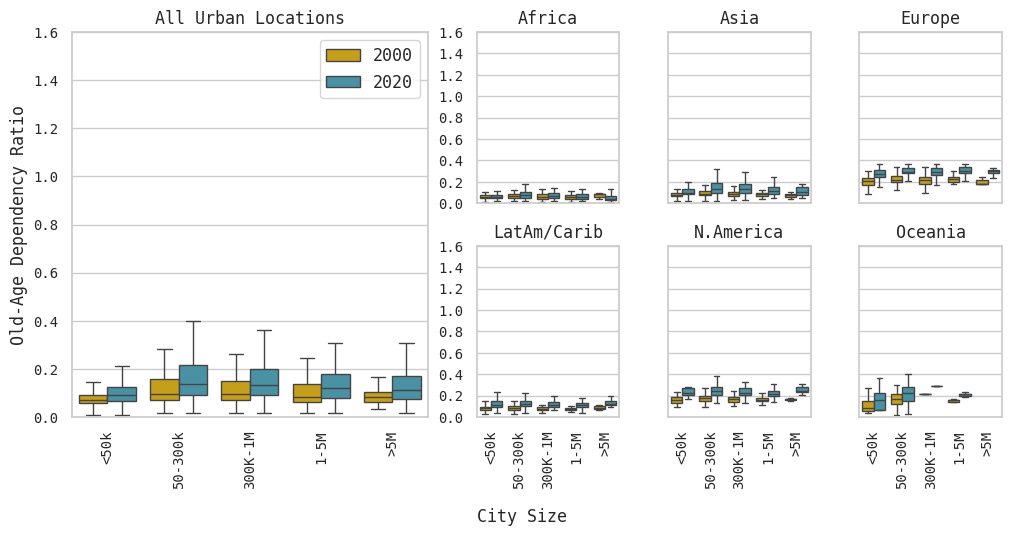

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

# prep data
boxplot_data = annual_metrics[['ID_UC_G0', 'year', 'old_dr', 'total_pop', 'Continent']].copy()
boxplot_data = boxplot_data[(boxplot_data['year'].isin([2000, 2020])) & (boxplot_data['Continent'] != "#N/A")]

#map continents
continent_map = {
    'Oceania': 'Oceania',
    'Australia and New Zealand': 'Oceania',
    'Latin America and the Caribbean': 'LatAm/Carib',
    'Sub-Saharan Africa': 'Africa',
    'Northern Africa and Western Asia': 'Africa',
    'Europe': 'Europe',
    'Central and Southern Asia': 'Asia',
    'Eastern and South-Eastern Asia': 'Asia',
    'Northern America': 'N.America'
}
boxplot_data['ContinentGroup'] = boxplot_data['Continent'].map(continent_map)
boxplot_data = boxplot_data.dropna(subset=['ContinentGroup'])

# define city size
def city_size_label(pop):
    if pop <= 50000:
        return "<50k"
    elif 50000 < pop <= 300000:
        return "50-300k"
    elif 300000 < pop <= 1000000:
        return "300K-1M"
    elif 1000000 < pop <= 5000000:
        return "1-5M"
    else:
        return ">5M"

city_size_order = ["<50k", "50-300k", "300K-1M", "1-5M", ">5M"]
boxplot_data['CitySize'] = pd.Categorical(
    boxplot_data['total_pop'].apply(city_size_label),
    categories=city_size_order, ordered=True
)
boxplot_data['year'] = boxplot_data['year'].astype(str)

# figure setup
sns.set(style="whitegrid")
mono_font = font_manager.FontProperties(family="DejaVu Sans Mono")
palette = {"2000":"#E1AF00", "2020":"#3B9AB2"}
continent_groups = ["Africa", "Asia", "Europe", "LatAm/Carib", "N.America", "Oceania"]

fig = plt.figure(figsize=(12, 5))
gs = GridSpec(2, 4, figure=fig, width_ratios=[2.5, 1, 1, 1], height_ratios=[1,1],
              wspace=0.25, hspace=0.25)

title_fontsize = 12
tick_fontsize_x = 10
tick_fontsize_y = 10

# left: all urban locations
ax_all = fig.add_subplot(gs[:, 0])
sns.boxplot(
    data=boxplot_data,
    x='CitySize',
    y='old_dr',
    hue='year',
    palette=palette,
    dodge=True,
    linewidth=1,
    fliersize=0,
    showfliers=False,
    ax=ax_all
)
ax_all.set_ylabel("Old-Age Dependency Ratio", fontproperties=mono_font, fontsize=title_fontsize)
ax_all.set_title("All Urban Locations", fontproperties=mono_font, fontsize=title_fontsize)
ax_all.set_ylim(0, 1.6)
ax_all.set_yticks([i*0.2 for i in range(9)])
ax_all.tick_params(axis='x', rotation=90, labelsize=tick_fontsize_x)
ax_all.set_xlabel(None)  # Remove the x-axis label


# manually set tick fonts
for tick in ax_all.get_yticklabels():
    tick.set_fontproperties(mono_font)
    tick.set_fontsize(tick_fontsize_y)
for tick in ax_all.get_xticklabels():
    tick.set_fontproperties(mono_font)
    tick.set_fontsize(tick_fontsize_x)

# legend only on main plot
handles, labels = ax_all.get_legend_handles_labels()
ax_all.legend(handles, labels, title="", prop=mono_font, loc='upper right')

# right: split by continent
for i, cont in enumerate(continent_groups):
    row = i // 3
    col = i % 3
    ax = fig.add_subplot(gs[row, col+1])
    cont_data = boxplot_data[boxplot_data['ContinentGroup'] == cont]
    
    sns.boxplot(
        data=cont_data,
        x='CitySize',
        y='old_dr',
        hue='year',
        palette=palette,
        dodge=True,
        linewidth=1,
        fliersize=0,
        showfliers=False,
        ax=ax
    )
    
    ax.set_title(cont, fontproperties=mono_font, fontsize=title_fontsize)
    ax.set_xlabel(None)  # Remove the x-axis label
    
    # show x-axis tick labels only on bottom row of subplots
    if row == 1:
        ax.set_xticks(range(len(city_size_order)))
        ax.set_xticklabels(city_size_order, fontproperties=mono_font, fontsize=tick_fontsize_x, rotation=90)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    # remove y-axis labels for non-left columns
    if col != 0:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("", fontproperties=mono_font, fontsize=title_fontsize)
    
    ax.set_ylim(0, 1.6)
    ax.set_yticks([i*0.2 for i in range(9)])
    
    # manually adjust y tick font size
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(mono_font)
        tick.set_fontsize(tick_fontsize_y)
    
    # remove legend from subplots
    ax.get_legend().remove()

# Single centered x-label under entire figure
fig.text(0.5, -0.1, "City Size", fontproperties=mono_font, fontsize=title_fontsize, ha='center')

output_file = Path(figure_folder) / 'figs5_citysize_odr.pdf'
fig.savefig(
    output_file,
    format="pdf",
    bbox_inches='tight',
    pad_inches=0,
    dpi=300
)

plt.show()


# Section S6: Total Dependency Ratio

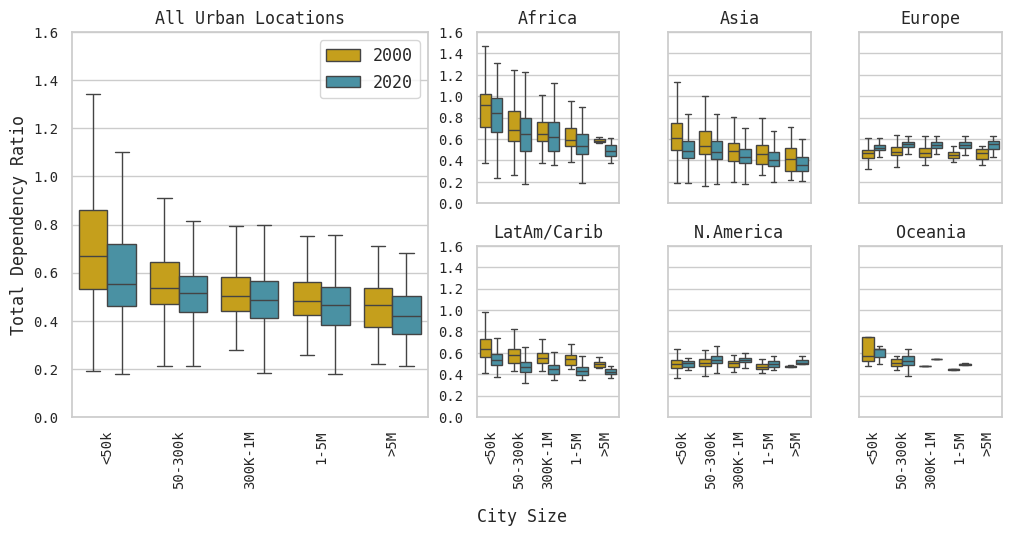

In [ ]:
# prep data
boxplot_data = annual_metrics[['ID_UC_G0', 'year', 'total_dr', 'total_pop', 'Continent']].copy()
boxplot_data = boxplot_data[(boxplot_data['year'].isin([2000, 2020])) & (boxplot_data['Continent'] != "#N/A")]

#map to continents
continent_map = {
    'Oceania': 'Oceania',
    'Australia and New Zealand': 'Oceania',
    'Latin America and the Caribbean': 'LatAm/Carib',
    'Sub-Saharan Africa': 'Africa',
    'Northern Africa and Western Asia': 'Africa',
    'Europe': 'Europe',
    'Central and Southern Asia': 'Asia',
    'Eastern and South-Eastern Asia': 'Asia',
    'Northern America': 'N.America'
}
boxplot_data['ContinentGroup'] = boxplot_data['Continent'].map(continent_map)
boxplot_data = boxplot_data.dropna(subset=['ContinentGroup'])

# set city size label based on total pop
def city_size_label(pop):
    if pop <= 50000:
        return "<50k"
    elif 50000 < pop <= 300000:
        return "50-300k"
    elif 300000 < pop <= 1000000:
        return "300K-1M"
    elif 1000000 < pop <= 5000000:
        return "1-5M"
    else:
        return ">5M"

city_size_order = ["<50k", "50-300k", "300K-1M", "1-5M", ">5M"]
boxplot_data['CitySize'] = pd.Categorical(
    boxplot_data['total_pop'].apply(city_size_label),
    categories=city_size_order, ordered=True
)
boxplot_data['year'] = boxplot_data['year'].astype(str)

# figure setup
sns.set(style="whitegrid")
mono_font = font_manager.FontProperties(family="DejaVu Sans Mono")
palette = {"2000":"#E1AF00", "2020":"#3B9AB2"}
continent_groups = ["Africa", "Asia", "Europe", "LatAm/Carib", "N.America", "Oceania"]

fig = plt.figure(figsize=(12, 5))
gs = GridSpec(2, 4, figure=fig, width_ratios=[2.5, 1, 1, 1], height_ratios=[1,1],
              wspace=0.25, hspace=0.25)

title_fontsize = 12
tick_fontsize_x = 10
tick_fontsize_y = 10

# left panel, all urban locations
ax_all = fig.add_subplot(gs[:, 0])
sns.boxplot(
    data=boxplot_data,
    x='CitySize',
    y='total_dr',
    hue='year',
    palette=palette,
    dodge=True,
    linewidth=1,
    fliersize=0,
    showfliers=False,
    ax=ax_all
)
ax_all.set_ylabel("Total Dependency Ratio", fontproperties=mono_font, fontsize=title_fontsize)
ax_all.set_title("All Urban Locations", fontproperties=mono_font, fontsize=title_fontsize)
ax_all.set_ylim(0, 1.6)
ax_all.set_yticks([i*0.2 for i in range(9)])
ax_all.tick_params(axis='x', rotation=90, labelsize=tick_fontsize_x)
ax_all.set_xlabel(None)  # Remove the x-axis label


# manually set tick fonts
for tick in ax_all.get_yticklabels():
    tick.set_fontproperties(mono_font)
    tick.set_fontsize(tick_fontsize_y)
for tick in ax_all.get_xticklabels():
    tick.set_fontproperties(mono_font)
    tick.set_fontsize(tick_fontsize_x)

# legend only on main plot
handles, labels = ax_all.get_legend_handles_labels()
ax_all.legend(handles, labels, title="", prop=mono_font, loc='upper right')

# right panel, split by location
for i, cont in enumerate(continent_groups):
    row = i // 3
    col = i % 3
    ax = fig.add_subplot(gs[row, col+1])
    cont_data = boxplot_data[boxplot_data['ContinentGroup'] == cont]
    
    sns.boxplot(
        data=cont_data,
        x='CitySize',
        y='total_dr',
        hue='year',
        palette=palette,
        dodge=True,
        linewidth=1,
        fliersize=0,
        showfliers=False,
        ax=ax
    )
    
    ax.set_title(cont, fontproperties=mono_font, fontsize=title_fontsize)
    ax.set_xlabel(None)  # Remove the x-axis label
    
    # show x-axis tick labels only on bottom row of subplots
    if row == 1:
        ax.set_xticks(range(len(city_size_order)))
        ax.set_xticklabels(city_size_order, fontproperties=mono_font, fontsize=tick_fontsize_x, rotation=90)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    # remove y-axis labels for non-left columns
    if col != 0:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("", fontproperties=mono_font, fontsize=title_fontsize)
    
    ax.set_ylim(0, 1.6)
    ax.set_yticks([i*0.2 for i in range(9)])
    
    # manually adjust y tick font size
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(mono_font)
        tick.set_fontsize(tick_fontsize_y)
    
    # remove legend from subplots
    ax.get_legend().remove()

# Single centered x-label under entire figure
fig.text(0.5, -0.1, "City Size", fontproperties=mono_font, fontsize=title_fontsize, ha='center')

output_file = Path(figure_folder) / 'figs6_citysize_tdr.pdf'
fig.savefig(
    output_file,
    format="pdf",
    bbox_inches='tight',
    pad_inches=0,
    dpi=300
)

plt.show()

# Section S7: Natural Growth V Migration by Continent

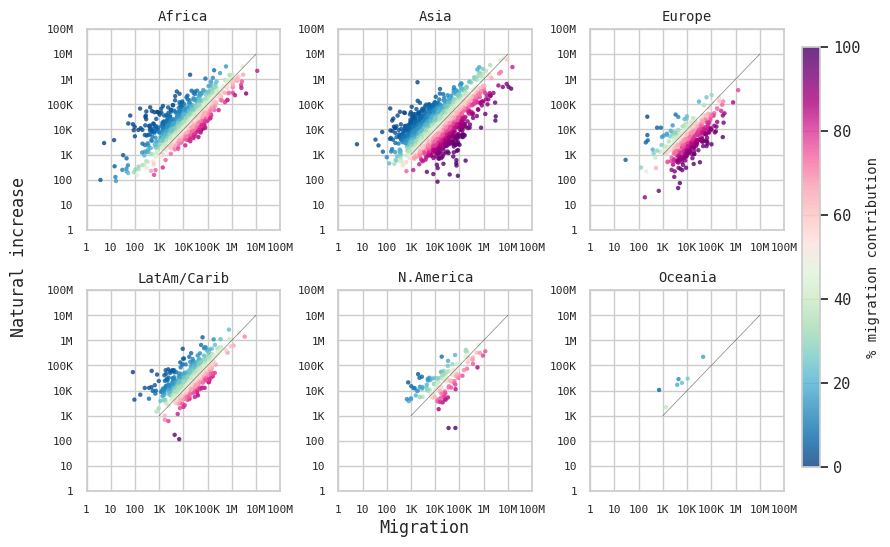

In [ ]:
# font setup
mono_font = FontProperties(family="DejaVu Sans Mono", size=8)
mpl.rcParams['font.family'] = mono_font.get_name()
mpl.rcParams['font.size'] = 8

# grab data
scatter_data = change_data.copy()
scatter_data = scatter_data[
    (scatter_data["total_migration"] > 0) &
    (scatter_data["natural_change"] > 0)
].copy()

# map to continents
continent_map = {
    'Oceania': 'Oceania',
    'Australia and New Zealand': 'Oceania',
    'Latin America and the Caribbean': 'LatAm/Carib',
    'Sub-Saharan Africa': 'Africa',
    'Northern Africa and Western Asia': 'Africa',
    'Europe': 'Europe',
    'Central and Southern Asia': 'Asia',
    'Eastern and South-Eastern Asia': 'Asia',
    'Northern America': 'N.America'
}
scatter_data['ContinentGroup'] = scatter_data['Continent'].map(continent_map)
scatter_data = scatter_data.dropna(subset=['ContinentGroup'])

# categorize city sizes
def city_size_label(pop):
    if pop <= 50000:
        return "<50k"
    elif 50000 < pop <= 300000:
        return "50-300k"
    elif 300000 < pop <= 1000000:
        return "300K-1M"
    elif 1000000 < pop <= 5000000:
        return "1-5M"
    else:
        return ">5M"

city_size_order = ["<50k", "50-300k", "300K-1M", "1-5M", ">5M"]
scatter_data['CitySize'] = pd.Categorical(
    scatter_data['total_pop_2020'].apply(city_size_label),
    categories=city_size_order, ordered=True
)

# colors
nat_colors = ['#084081','#0868ac','#2b8cbe','#4eb3d3','#7bccc4','#a8ddb5','#ccebc5','#e0f3db']
mig_colors = ['#fde0dd','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177','#49006a']
full_colors = nat_colors + mig_colors
cmap = mcolors.LinearSegmentedColormap.from_list("migration", full_colors)
norm = mcolors.Normalize(0, 100)

# figure setup
continent_groups = ["Africa", "Asia", "Europe", "LatAm/Carib", "N.America", "Oceania"]
n_cont = len(continent_groups)
cols = 3
rows = int(np.ceil(n_cont / cols))

fig = plt.figure(figsize=(cols*3, rows*3))
gs = GridSpec(rows, cols, figure=fig, wspace=0.3, hspace=0.3)

lims = [1e3, 1e7]
ticks = [1,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8]
labels = ["1","10","100","1K","10K","100K","1M","10M","100M"]

for i, cont in enumerate(continent_groups):
    row = i // cols
    col = i % cols
    ax = fig.add_subplot(gs[row, col])
    
    df = scatter_data[scatter_data['ContinentGroup'] == cont]
    
    sc = ax.scatter(
        df["total_migration"],
        df["natural_change"],
        c=df["perc_from_migration"],
        cmap=cmap,
        norm=norm,
        s=10,
        edgecolor="black",
        linewidth=0.0001,
        alpha=0.8
    )
    
    # 1:1 line
    ax.plot(lims, lims, color="black", linewidth=0.5, alpha=0.5)
    
    # log scale & limits
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    # ticks
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, fontproperties=mono_font)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels, fontproperties=mono_font)
    
    ax.set_title(cont, fontproperties=mono_font, fontsize=10)
    
# make labels in the center
fig.text(0.5, 0.04, "Migration", ha='center', fontproperties=mono_font, fontsize=12)
fig.text(0.04, 0.5, "Natural increase", va='center', rotation='vertical', fontproperties=mono_font, fontsize=12)

# colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label("% migration contribution", fontproperties=mono_font, fontsize = 10)

output_file = Path(figure_folder) / 'figs7_migration_continent.pdf'
fig.savefig(
    output_file,
    format="pdf",
    bbox_inches='tight',
    pad_inches=0,
    dpi=300
)

plt.show()


# Section S10.2 - Main manuscript figures with dynamic boundaries

In [ ]:
# load the dynamic boundary data
annual_metrics_dynamic = pd.read_csv(Path(data_folder) / '04_final_demographic_data/02_dynamic_boundaries/gudd_annual_metrics_dynamic_boundaries.csv')
change_data_dynamic = pd.read_csv(Path(data_folder) / '04_final_demographic_data/02_dynamic_boundaries/gudd_change_2000_2020_dynamic_boundaries.csv')

/tmp/ipykernel_8173/815483676.py:1: DtypeWarning: Columns (0: Name, 1: Country, 2: Continent, 3: Development) have mixed types. Specify dtype option on import or set low_memory=False.
  annual_metrics_dynamic = pd.read_csv(Path(data_folder) / '04_final_demographic_data/02_dynamic_boundaries/gudd_annual_metrics_dynamic_boundaries.csv')


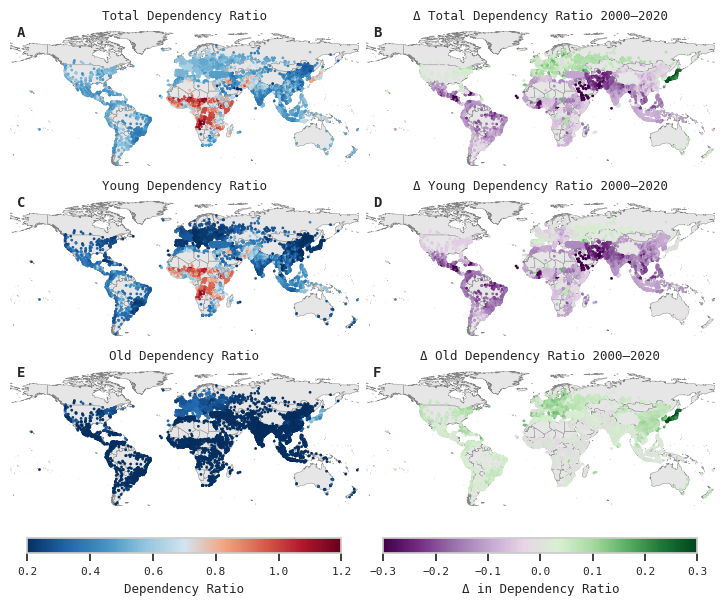

In [ ]:
# FIGURE 1

# limit annual metrics to only include 2020, for plotting
annual_metrics_dynamic_2020 = annual_metrics_dynamic[
    (annual_metrics_dynamic["YearOfBirth"] <= 2000) &
    (annual_metrics_dynamic["YearOfDeath"] >= 2020) &
    (annual_metrics_dynamic["year"] == 2020)
].copy()

change_data_dynamic = change_data_dynamic[
    (change_data_dynamic["YearOfBirth"] <= 2000) &
    (change_data_dynamic["YearOfDeath"] >= 2020)
].copy()

world = gpd.read_file(Path(data_folder) / '02_auxiliary_data/03_mapping/ne_50m_admin_0_countries.shp')

# set colors
# dependency ratio colors
colors_dr = [
    "#053061", "#2166AC", "#4393C3", "#92C5DE",
    "#D1E5F0", "#F4A582", "#D6604D", "#B2182B", "#67001F"
]

# change colors
colors_delta = [
    "#40004B", "#762A83", "#9970AB", "#C2A5CF", "#E7D4E8",
    "#D9F0D3", "#A6DBA0", "#5AAE61", "#1B7837", "#00441B"
]

cmap_dr = mcolors.LinearSegmentedColormap.from_list("dr", colors_dr)
cmap_delta = mcolors.LinearSegmentedColormap.from_list("delta", colors_delta)

import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib import colors
from pathlib import Path
import geopandas as gpd
import numpy as np

# Font setup
font_prop = font_manager.FontProperties(family="DejaVu Sans Mono")
subplot_letters = ["A", "B", "C", "D", "E", "F"]

# Function to slightly darken a color
def darken_color(c, amount=0.01):
    """
    Darken a matplotlib color by multiplying its RGB components by `amount`.
    """
    c_rgb = colors.to_rgb(c)
    return tuple(np.array(c_rgb) * amount)

# Map plotting function
def plot_map(ax, data, column, cmap, vmin, vmax, title, letter=None):
    # Basemap
    world.plot(
        ax=ax,
        color="#E6E6E6",
        edgecolor="0.5",
        linewidth=0.3,
        zorder=1
    )

    # Normalize colors to colormap
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    rgba_colors = cmap(norm(data[column]))

    # Slightly darker edge color for each point
    edge_colors = np.array([darken_color(c[:3], 0.6) + (c[3],) for c in rgba_colors])

    # Scatter
    sc = ax.scatter(
        data["longitude"],
        data["latitude"],
        c=rgba_colors,
        s=4,
        edgecolor=edge_colors,
        linewidth=0.0005,
        zorder=2
    )

    # Axis styling
    ax.set_xlim(-180, 180)
    ax.set_ylim(-55, 90)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(True, linestyle="--", linewidth=0.3, alpha=1)

    # Title
    ax.set_title(
        title,
        fontproperties=font_prop,
        fontsize=9,
        pad=4
    )

    # Subplot letter
    if letter:
        ax.text(
            0.02, 1, letter,
            transform=ax.transAxes,
            fontproperties=font_prop,
            fontsize=10,
            fontweight="bold",
            va="top",
            ha="left",
            zorder=3
        )

    return sc, norm

# Figure setup
fig, axes = plt.subplots(
    3, 2,
    figsize=(7.087, 6),  # 180mm x 
    constrained_layout=True
)

# Spacing pads
fig.set_constrained_layout_pads(
    w_pad=0.02,
    h_pad=0.02,
    hspace=0.02,
    wspace=0.02
)

# Plot each map
sc1, norm1 = plot_map(axes[0,0], annual_metrics_dynamic_2020, "total_dr", cmap_dr, 0.2, 1.2,
                      "Total Dependency Ratio", letter=subplot_letters[0])

sc2, norm2 = plot_map(axes[0,1], change_data_dynamic, "total_dr_Delta", cmap_delta, -0.3, 0.3,
                      "Δ Total Dependency Ratio 2000–2020", letter=subplot_letters[1])

sc3, norm3 = plot_map(axes[1,0], annual_metrics_dynamic_2020, "young_dr", cmap_dr, 0.2, 1.2,
                      "Young Dependency Ratio", letter=subplot_letters[2])

sc4, norm4 = plot_map(axes[1,1], change_data_dynamic, "young_dr_Delta", cmap_delta, -0.3, 0.3,
                      "Δ Young Dependency Ratio 2000–2020", letter=subplot_letters[3])

sc5, norm5 = plot_map(axes[2,0], annual_metrics_dynamic_2020, "old_dr", cmap_dr, 0.2, 1.2,
                      "Old Dependency Ratio", letter=subplot_letters[4])

sc6, norm6 = plot_map(axes[2,1], change_data_dynamic, "old_dr_Delta", cmap_delta, -0.3, 0.3,
                      "Δ Old Dependency Ratio 2000–2020", letter=subplot_letters[5])

# Colorbars (horizontal, compact)
cbar1 = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm1, cmap=cmap_dr),
    ax=axes[:,0],
    orientation="horizontal",
    fraction=0.04,
    pad=0.06,
    shrink=0.9
)

cbar2 = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm2, cmap=cmap_delta),
    ax=axes[:,1],
    orientation="horizontal",
    fraction=0.04,
    pad=0.06,
    shrink=0.9
)

# Colorbar labels
for cbar, label in zip([cbar1, cbar2], ["Dependency Ratio", "Δ in Dependency Ratio"]):
    cbar.ax.tick_params(labelsize=8)
    cbar.ax.set_xlabel(label, fontsize=9, fontproperties=font_prop)

# Save as  PDF,
output_file = Path(figure_folder) / 'figs10_1_udr_map.pdf'
fig.savefig(
    output_file,
    format="pdf",
    bbox_inches='tight',
    pad_inches=0,
    dpi=300
)

plt.show()

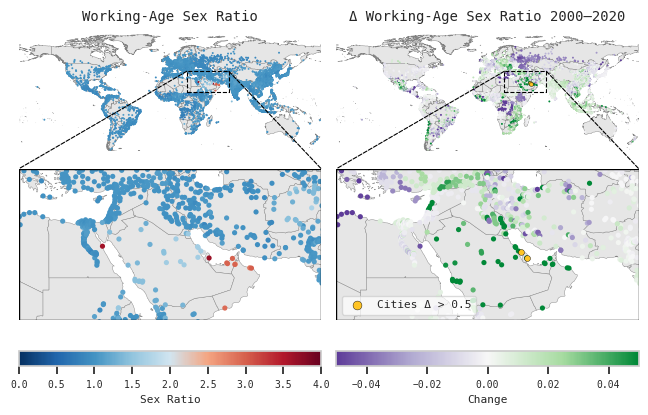

In [ ]:
# prepare data
boxplot_data = annual_metrics[['ID_UC_G0', 'year', 'young_dr', 'total_pop', 'Continent']].copy()
boxplot_data = boxplot_data[(boxplot_data['year'].isin([2000, 2020])) & (boxplot_data['Continent'] != "#N/A")]

# map continents to continent groups
continent_map = {
    'Oceania': 'Oceania',
    'Australia and New Zealand': 'Oceania',
    'Latin America and the Caribbean': 'LatAm/Carib',
    'Sub-Saharan Africa': 'Africa',
    'Northern Africa and Western Asia': 'Africa',
    'Europe': 'Europe',
    'Central and Southern Asia': 'Asia',
    'Eastern and South-Eastern Asia': 'Asia',
    'Northern America': 'N.America'
}
boxplot_data['ContinentGroup'] = boxplot_data['Continent'].map(continent_map)
boxplot_data = boxplot_data.dropna(subset=['ContinentGroup'])

# categorize city size based on population thresholds
def city_size_label(pop):
    if pop <= 50000:
        return "<50k"
    elif 50000 < pop <= 300000:
        return "50-300k"
    elif 300000 < pop <= 1000000:
        return "300K-1M"
    elif 1000000 < pop <= 5000000:
        return "1-5M"
    else:
        return ">5M"

city_size_order = ["<50k", "50-300k", "300K-1M", "1-5M", ">5M"]
boxplot_data['CitySize'] = pd.Categorical(
    boxplot_data['total_pop'].apply(city_size_label),
    categories=city_size_order, ordered=True
)
boxplot_data['year'] = boxplot_data['year'].astype(str)

# figure setup
sns.set(style="whitegrid")
mono_font = font_manager.FontProperties(family="DejaVu Sans Mono")
palette = {"2000":"#E1AF00", "2020":"#3B9AB2"}
continent_groups = ["Africa", "Asia", "Europe", "LatAm/Carib", "N.America", "Oceania"]

fig = plt.figure(figsize=(12, 5))
gs = GridSpec(2, 4, figure=fig, width_ratios=[2.5, 1, 1, 1], height_ratios=[1,1],
              wspace=0.25, hspace=0.25)

title_fontsize = 12
tick_fontsize_x = 10
tick_fontsize_y = 10

# left panel - all urban locations
ax_all = fig.add_subplot(gs[:, 0])
sns.boxplot(
    data=boxplot_data,
    x='CitySize',
    y='young_dr',
    hue='year',
    palette=palette,
    dodge=True,
    linewidth=1,
    fliersize=0,
    showfliers=False,
    ax=ax_all
)
ax_all.set_ylabel("Young Dependency Ratio", fontproperties=mono_font, fontsize=title_fontsize)
ax_all.set_title("All Urban Locations", fontproperties=mono_font, fontsize=title_fontsize)
ax_all.set_ylim(0, 1.6)
ax_all.set_yticks([i*0.2 for i in range(9)])
ax_all.tick_params(axis='x', rotation=90, labelsize=tick_fontsize_x)
ax_all.set_xlabel(None)  # remove the x axis label


# manually set tick fonts
for tick in ax_all.get_yticklabels():
    tick.set_fontproperties(mono_font)
    tick.set_fontsize(tick_fontsize_y)
for tick in ax_all.get_xticklabels():
    tick.set_fontproperties(mono_font)
    tick.set_fontsize(tick_fontsize_x)

# legend only on main plot
handles, labels = ax_all.get_legend_handles_labels()
ax_all.legend(handles, labels, title="", prop=mono_font, loc='upper right')

# right panel - split by continent
for i, cont in enumerate(continent_groups):
    row = i // 3
    col = i % 3
    ax = fig.add_subplot(gs[row, col+1])
    cont_data = boxplot_data[boxplot_data['ContinentGroup'] == cont]
    
    sns.boxplot(
        data=cont_data,
        x='CitySize',
        y='young_dr',
        hue='year',
        palette=palette,
        dodge=True,
        linewidth=1,
        fliersize=0,
        showfliers=False,
        ax=ax
    )
    
    ax.set_title(cont, fontproperties=mono_font, fontsize=title_fontsize)
    ax.set_xlabel(None)  # remove the x-axis label
    
    # show x-axis tick labels only on bottom row of subplots
    if row == 1:
        ax.set_xticks(range(len(city_size_order)))
        ax.set_xticklabels(city_size_order, fontproperties=mono_font, fontsize=tick_fontsize_x, rotation=90)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    # remove y-axis labels for non-left columns
    if col != 0:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("", fontproperties=mono_font, fontsize=title_fontsize)
    
    ax.set_ylim(0, 1.6)
    ax.set_yticks([i*0.2 for i in range(9)])
    
    # manually adjust y tick font size
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(mono_font)
        tick.set_fontsize(tick_fontsize_y)
    
    # remove legend from subplots
    ax.get_legend().remove()

# single centered x label under the entire figure
fig.text(0.5, -0.1, "City Size", fontproperties=mono_font, fontsize=title_fontsize, ha='center')

output_file = Path(figure_folder) / 'fig3_citysize_ydr.pdf'
fig.savefig(
    output_file,
    format="pdf",
    bbox_inches='tight',
    pad_inches=0,
    dpi=300
)

plt.show()


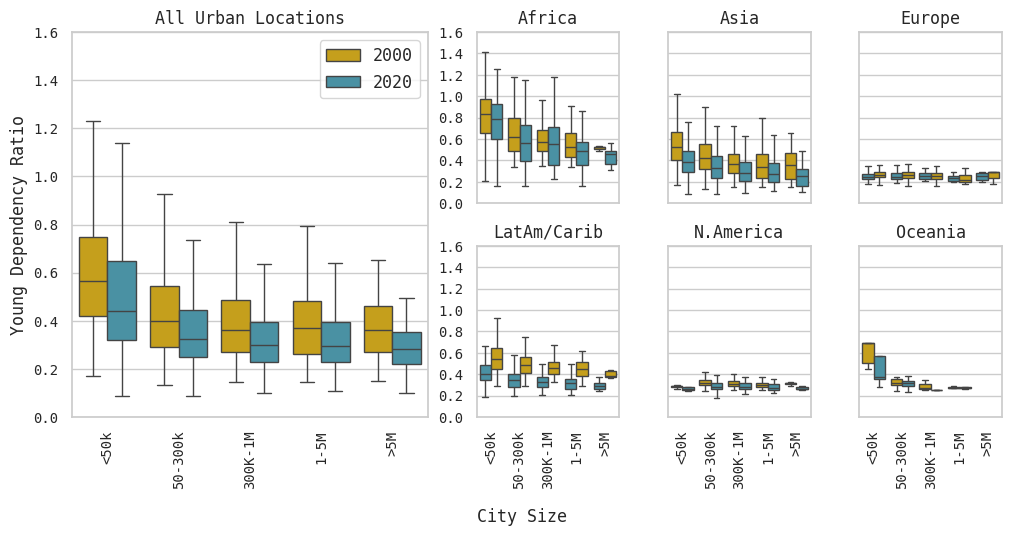

In [ ]:
# prepare data
boxplot_data = annual_metrics_dynamic[['ID_UC_G0', 'year', 'young_dr', 'total_pop', 'Continent']].copy()
boxplot_data = boxplot_data[(boxplot_data['year'].isin([2000, 2020])) & (boxplot_data['Continent'] != "#N/A")]

# map continents to continent groups
continent_map = {
    'Oceania': 'Oceania',
    'Australia and New Zealand': 'Oceania',
    'Latin America and the Caribbean': 'LatAm/Carib',
    'Sub-Saharan Africa': 'Africa',
    'Northern Africa and Western Asia': 'Africa',
    'Europe': 'Europe',
    'Central and Southern Asia': 'Asia',
    'Eastern and South-Eastern Asia': 'Asia',
    'Northern America': 'N.America'
}
boxplot_data['ContinentGroup'] = boxplot_data['Continent'].map(continent_map)
boxplot_data = boxplot_data.dropna(subset=['ContinentGroup'])

# categorize city size based on population thresholds
def city_size_label(pop):
    if pop <= 50000:
        return "<50k"
    elif 50000 < pop <= 300000:
        return "50-300k"
    elif 300000 < pop <= 1000000:
        return "300K-1M"
    elif 1000000 < pop <= 5000000:
        return "1-5M"
    else:
        return ">5M"

city_size_order = ["<50k", "50-300k", "300K-1M", "1-5M", ">5M"]
boxplot_data['CitySize'] = pd.Categorical(
    boxplot_data['total_pop'].apply(city_size_label),
    categories=city_size_order, ordered=True
)
boxplot_data['year'] = boxplot_data['year'].astype(str)

# figure setup
sns.set(style="whitegrid")
mono_font = font_manager.FontProperties(family="DejaVu Sans Mono")
palette = {"2000":"#E1AF00", "2020":"#3B9AB2"}
continent_groups = ["Africa", "Asia", "Europe", "LatAm/Carib", "N.America", "Oceania"]

fig = plt.figure(figsize=(12, 5))
gs = GridSpec(2, 4, figure=fig, width_ratios=[2.5, 1, 1, 1], height_ratios=[1,1],
              wspace=0.25, hspace=0.25)

title_fontsize = 12
tick_fontsize_x = 10
tick_fontsize_y = 10

# left panel - all urban locations
ax_all = fig.add_subplot(gs[:, 0])
sns.boxplot(
    data=boxplot_data,
    x='CitySize',
    y='young_dr',
    hue='year',
    palette=palette,
    dodge=True,
    linewidth=1,
    fliersize=0,
    showfliers=False,
    ax=ax_all
)
ax_all.set_ylabel("Young Dependency Ratio", fontproperties=mono_font, fontsize=title_fontsize)
ax_all.set_title("All Urban Locations", fontproperties=mono_font, fontsize=title_fontsize)
ax_all.set_ylim(0, 1.6)
ax_all.set_yticks([i*0.2 for i in range(9)])
ax_all.tick_params(axis='x', rotation=90, labelsize=tick_fontsize_x)
ax_all.set_xlabel(None)  # remove the x axis label


# manually set tick fonts
for tick in ax_all.get_yticklabels():
    tick.set_fontproperties(mono_font)
    tick.set_fontsize(tick_fontsize_y)
for tick in ax_all.get_xticklabels():
    tick.set_fontproperties(mono_font)
    tick.set_fontsize(tick_fontsize_x)

# legend only on main plot
handles, labels = ax_all.get_legend_handles_labels()
ax_all.legend(handles, labels, title="", prop=mono_font, loc='upper right')

# right panel - split by continent
for i, cont in enumerate(continent_groups):
    row = i // 3
    col = i % 3
    ax = fig.add_subplot(gs[row, col+1])
    cont_data = boxplot_data[boxplot_data['ContinentGroup'] == cont]
    
    sns.boxplot(
        data=cont_data,
        x='CitySize',
        y='young_dr',
        hue='year',
        palette=palette,
        dodge=True,
        linewidth=1,
        fliersize=0,
        showfliers=False,
        ax=ax
    )
    
    ax.set_title(cont, fontproperties=mono_font, fontsize=title_fontsize)
    ax.set_xlabel(None)  # remove the x-axis label
    
    # show x-axis tick labels only on bottom row of subplots
    if row == 1:
        ax.set_xticks(range(len(city_size_order)))
        ax.set_xticklabels(city_size_order, fontproperties=mono_font, fontsize=tick_fontsize_x, rotation=90)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    # remove y-axis labels for non-left columns
    if col != 0:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("", fontproperties=mono_font, fontsize=title_fontsize)
    
    ax.set_ylim(0, 1.6)
    ax.set_yticks([i*0.2 for i in range(9)])
    
    # manually adjust y tick font size
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(mono_font)
        tick.set_fontsize(tick_fontsize_y)
    
    # remove legend from subplots
    ax.get_legend().remove()

# single centered x label under the entire figure
fig.text(0.5, -0.1, "City Size", fontproperties=mono_font, fontsize=title_fontsize, ha='center')

output_file = Path(figure_folder) / 'fig3_citysize_ydr.pdf'
fig.savefig(
    output_file,
    format="pdf",
    bbox_inches='tight',
    pad_inches=0,
    dpi=300
)

plt.show()


/tmp/ipykernel_8173/2325219908.py:286: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bar.set_yticklabels(


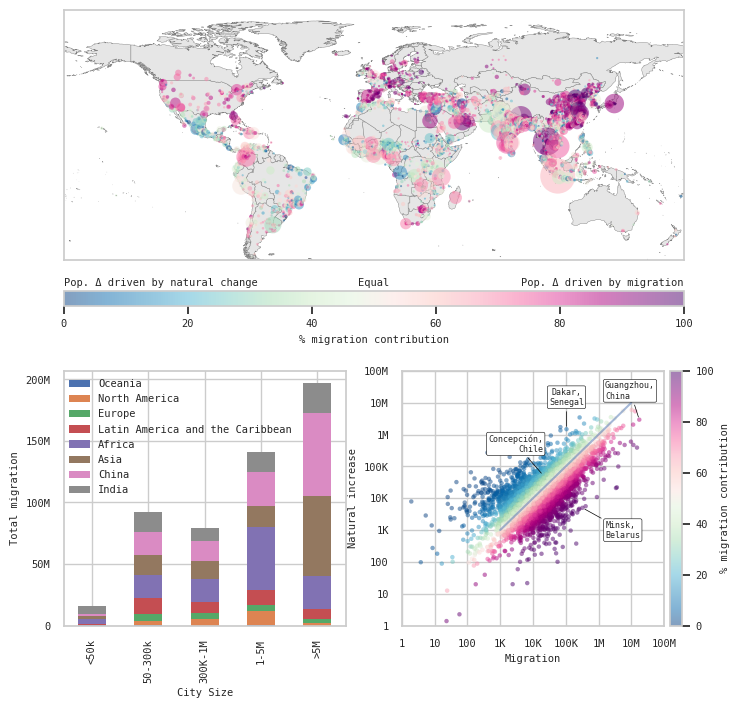

In [ ]:
# font setup
font_prop = FontProperties(family="DejaVu Sans Mono", size=7.5)  # all non-city elements
small_font = font_prop  # for ticks or smaller text if needed
label_font = FontProperties(family="DejaVu Sans Mono", size=6)  # city labels remain smaller

mpl.rcParams['font.family'] = font_prop.get_name()
mpl.rcParams['font.size'] = font_prop.get_size()

# data preparation
migration_map_data = change_data_dynamic.copy()

migration_map_data = migration_map_data[
    (migration_map_data["total_migration"] > 0) &
    (migration_map_data["natural_change"] > 0)
].copy()

# continent mapping - rest of asia here for figure
continent_map = {

'Oceania': 'Oceania',
'Australia and New Zealand': 'Oceania',

'Latin America and the Caribbean': 'Latin America and the Caribbean',

'Sub-Saharan Africa': 'Africa',
'Northern Africa and Western Asia': 'Africa',

'Europe': 'Europe',

'Central and Southern Asia': 'Rest of Asia',
'Eastern and South-Eastern Asia': 'Rest of Asia',

'Northern America': 'North America'

}

migration_map_data["Continent"] = migration_map_data["Continent"].map(continent_map)

migration_map_data.loc[
migration_map_data["Country"]=="China","Continent"]="China"

migration_map_data.loc[
migration_map_data["Country"]=="India","Continent"]="India"

# city size delineation
def city_size_label(pop):

    if pop <= 50000:
        return "<50k"
    elif pop <= 300000:
        return "50-300k"
    elif pop <= 1000000:
        return "300K-1M"
    elif pop <= 5000000:
        return "1-5M"
    else:
        return ">5M"


city_size_order = ["<50k","50-300k","300K-1M","1-5M",">5M"]

migration_map_data["CitySize"] = pd.Categorical(
migration_map_data["total_pop_2020"].apply(city_size_label),
categories=city_size_order,
ordered=True
)

# stacked bar plot
stacked_data = migration_map_data.groupby(
["CitySize","Continent"],as_index=False
)["total_migration"].sum()

continent_order = [
"Oceania",
"North America",
"Europe",
"Latin America and the Caribbean",
"Africa",
"Rest of Asia",
"China",
"India"
]

stacked_data = stacked_data[
stacked_data["Continent"].isin(continent_order)
]

stacked_pivot = stacked_data.pivot_table(
index="CitySize",
columns="Continent",
values="total_migration",
fill_value=0
).reindex(index=city_size_order,columns=continent_order)

# color palettes
nat_colors = ['#084081','#0868ac','#2b8cbe','#4eb3d3',
'#7bccc4','#a8ddb5','#ccebc5','#e0f3db']

mig_colors = ['#fde0dd','#fcc5c0','#fa9fb5','#f768a1',
'#dd3497','#ae017e','#7a0177','#49006a']

full_colors = nat_colors + mig_colors

cmap = mcolors.LinearSegmentedColormap.from_list(
"migration",
full_colors
)

norm = mcolors.Normalize(0,100)

# size scale, setting min and max for point size
sizes = np.interp(
migration_map_data["total_pop_Delta"],
(
migration_map_data["total_pop_Delta"].min(),
migration_map_data["total_pop_Delta"].max()
),
(2,800)
)

# figure layout
fig = plt.figure(figsize=(8,8))

gs = GridSpec(
2,2,
height_ratios=[1.2,1],
hspace=0.2,
wspace=0.20
)

# PANEL A
ax_map = fig.add_subplot(gs[0,:])

world.plot(
ax=ax_map,
color="#E6E6E6",
edgecolor="0.5",
linewidth=0.3
)

sc_map = ax_map.scatter(
migration_map_data.longitude,
migration_map_data.latitude,
c=migration_map_data.perc_from_migration,
cmap=cmap,
norm=norm,
s=sizes,
edgecolor="black",
linewidth=0,
alpha=0.5
)

ax_map.set_xlim(-180,180)
ax_map.set_ylim(-55,90)

ax_map.set_xticks([])
ax_map.set_yticks([])

# wider colorbar
cbar = fig.colorbar(
sc_map,
ax=ax_map,
orientation="horizontal",

fraction=0.08,   # wider
pad=0.10,
aspect=40        # wider shape
)

cbar.set_label(
    "% migration contribution",
    fontproperties=font_prop
)

# smaller tick font
for tick in cbar.ax.get_xticklabels():
    tick.set_fontproperties(font_prop)

# top labels above colorbar to indicate direction of mig/nat change
cbar.ax.text(
0.0, 1.2,
"Pop. Δ driven by natural change",
ha='left',
va='bottom',
transform=cbar.ax.transAxes,
fontproperties=font_prop
)

cbar.ax.text(
0.5, 1.2,
"Equal",
ha='center',
va='bottom',
transform=cbar.ax.transAxes,
fontproperties=font_prop
)

cbar.ax.text(
1.0, 1.2,
"Pop. Δ driven by migration",
ha='right',
va='bottom',
transform=cbar.ax.transAxes,
fontproperties=font_prop
)

# PANEL B
ax_bar = fig.add_subplot(gs[1,0])

stacked_pivot.plot(
kind="bar",
stacked=True,
ax=ax_bar,
linewidth=0
)

ax_bar.set_ylabel(
"Total migration",
fontproperties=font_prop
)

yticks = ax_bar.get_yticks()

ax_bar.set_yticklabels(
[f"{int(y/1e6)}M" if y>0 else "0" for y in yticks],
fontproperties=font_prop
)

for tick in ax_bar.get_xticklabels():
    tick.set_fontproperties(font_prop)

handles,labels = ax_bar.get_legend_handles_labels()

fig.legend(
    handles,
    labels,
    prop=font_prop,
    frameon=False,
    loc="upper left",
    bbox_to_anchor=(0.12,0.43)
)
ax_bar.set_xlabel("City Size",fontproperties=font_prop)

ax_bar.get_legend().remove()

# PANEL C
ax_scatter = fig.add_subplot(gs[1,1])

sc = ax_scatter.scatter(
migration_map_data["total_migration"],
migration_map_data["natural_change"],
c=migration_map_data["perc_from_migration"],
cmap=cmap,
norm=norm,
s=10,
edgecolor="black",
linewidth=0.01,
alpha=0.5
)

ax_scatter.set_xscale("log")
ax_scatter.set_yscale("log")

lims = [1e3,1e7]

ax_scatter.set_xlim(lims)
ax_scatter.set_ylim(lims)

ax_scatter.plot(
lims,
lims,
alpha=0.5
)

ticks = [1,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8]

labels = ["1","10","100","1K","10K","100K","1M","10M","100M"]

ax_scatter.set_xticks(ticks)
ax_scatter.set_xticklabels(labels,fontproperties=font_prop)

ax_scatter.set_yticks(ticks)
ax_scatter.set_yticklabels(labels,fontproperties=font_prop)

ax_scatter.set_xlabel("Migration",fontproperties=font_prop)
ax_scatter.set_ylabel("Natural increase",fontproperties=font_prop)


# scatter colorbar
cbar2 = fig.colorbar(
sc,
ax=ax_scatter,
fraction=0.05,
pad=0.02
)
for tick in cbar2.ax.get_yticklabels():  # for vertical colorbar
    tick.set_fontproperties(font_prop)

for tick in cbar2.ax.get_xticklabels():  # in case orientation='horizontal'
    tick.set_fontproperties(font_prop)


cbar2.set_label(
"% migration contribution",
fontproperties=font_prop
)

# Label selected cities
label_font = FontProperties(family="DejaVu Sans Mono", size=6)

label_specs = {

    ("Guangzhou", "China"): {
        "xmult": 0.09,
        "ymult": 4.0,
        "ha": "left",
        "va": "bottom"
    },

    ("Dakar", "Senegal"): {
        "xmult": 1.0,
        "ymult": 5.0,
        "ha": "center",
        "va": "bottom"
    },

    ("Minsk", "Belarus"): {
        "xmult": 5.0,
        "ymult": 0.4,
        "ha": "left",
        "va": "top"
    },

    ("Concepción", "Chile"): {
        "xmult": 1,
        "ymult": 20.0,
        "ha": "right",
        "va": "top"
    },


}

for (name, country), spec in label_specs.items():

    row = migration_map_data[
        (migration_map_data["Name"] == name) &
        (migration_map_data["Country"] == country)
    ]

    if row.empty:
        continue

    x = row["total_migration"].values[0]
    y = row["natural_change"].values[0]

    x_text = x * spec["xmult"]
    y_text = y * spec["ymult"]

    label_text = f"{name},\n{country}"

    ax_scatter.annotate(
        label_text,
        xy=(x, y),
        xytext=(x_text, y_text),
        textcoords="data",
        arrowprops=dict(
            arrowstyle="-",
            linewidth=0.5,
            color="black"
        ),
        bbox=dict(
            boxstyle="round,pad=0.2",
            fc="white",
            ec="black",
            linewidth=0.4
        ),
        fontproperties=label_font,
        ha=spec["ha"],
        va=spec["va"]
    )

# save and show plot
output_file = Path(figure_folder) / 'fig4_migration.pdf'
fig.savefig(
    output_file,
    format="pdf",
    bbox_inches='tight',
    pad_inches=0,
    dpi=300
)

plt.show()

# Section 12 - Figure 1 with independent colorbars

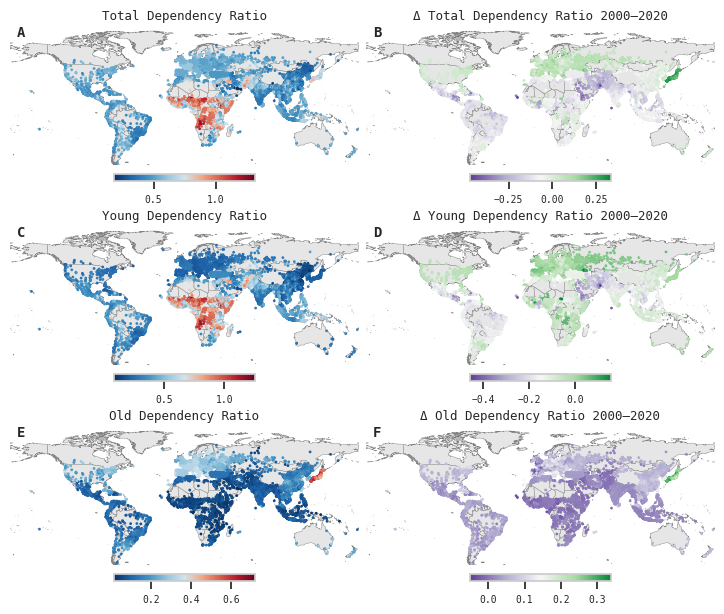

In [ ]:
# font setup
font_prop = font_manager.FontProperties(family="DejaVu Sans Mono")
subplot_letters = ["A", "B", "C", "D", "E", "F"]

# Function to slightly darken a color
def darken_color(c, amount=0.01):
    c_rgb = colors.to_rgb(c)
    return tuple(np.array(c_rgb) * amount)

# Map plotting function
def plot_map(ax, data, column, cmap, title, letter=None):
    # Basemap
    world.plot(
        ax=ax,
        color="#E6E6E6",
        edgecolor="0.5",
        linewidth=0.3,
        zorder=1
    )

    # Normalize colors per subplot
    vmin, vmax = data[column].min(), data[column].max()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    rgba_colors = cmap(norm(data[column]))

    # Darker edge color
    edge_colors = np.array([darken_color(c[:3], 0.6) + (c[3],) for c in rgba_colors])

    # Scatter
    sc = ax.scatter(
        data["longitude"],
        data["latitude"],
        c=rgba_colors,
        s=4,
        edgecolor=edge_colors,
        linewidth=0.0005,
        zorder=2
    )

    # Axis styling
    ax.set_xlim(-180, 180)
    ax.set_ylim(-55, 90)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(True, linestyle="--", linewidth=0.3, alpha=1)

    # Title
    ax.set_title(title, fontproperties=font_prop, fontsize=9, pad=4)

    # Subplot letter
    if letter:
        ax.text(
            0.02, 1, letter,
            transform=ax.transAxes,
            fontproperties=font_prop,
            fontsize=10,
            fontweight="bold",
            va="top",
            ha="left",
            zorder=3
        )

    # Add colorbar for this subplot
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        ax=ax,
        orientation="horizontal",
        fraction=0.045,
        pad=0.05
    )
    cbar.ax.tick_params(labelsize=7)
    return sc, norm, cbar

# -------------------
# Figure setup
# -------------------
fig, axes = plt.subplots(
    3, 2,
    figsize=(7.087, 6),
    constrained_layout=True
)

fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, hspace=0.02, wspace=0.02)

# Plot each map with individual colorbars
plots = [
    (axes[0,0], annual_metrics_2020, "total_dr", cmap_dr, "Total Dependency Ratio", subplot_letters[0]),
    (axes[0,1], change_data, "total_dr_Delta", cmap_delta, "Δ Total Dependency Ratio 2000–2020", subplot_letters[1]),
    (axes[1,0], annual_metrics_2020, "young_dr", cmap_dr, "Young Dependency Ratio", subplot_letters[2]),
    (axes[1,1], change_data, "young_dr_Delta", cmap_delta, "Δ Young Dependency Ratio 2000–2020", subplot_letters[3]),
    (axes[2,0], annual_metrics_2020, "old_dr", cmap_dr, "Old Dependency Ratio", subplot_letters[4]),
    (axes[2,1], change_data, "old_dr_Delta", cmap_delta, "Δ Old Dependency Ratio 2000–2020", subplot_letters[5])
]

for ax, data, col, cmap, title, letter in plots:
    plot_map(ax, data, col, cmap, title, letter=letter)

# Save as PDF
output_file = Path(figure_folder) / 'fig1_udr_map_individual_cbar.pdf'
fig.savefig(output_file, format="pdf", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()
